In [31]:
!pip install kagglehub
!pip install easygui

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.7/92.7 kB 3.6 MB/s eta 0:00:00


In [9]:
!pip install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 1.9 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.5 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.8 MB/s eta 0:00:00a 0:00:01


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sujaradha/thermal-images-diseased-healthy-leaves-paddy")

print("Path to dataset files:", path)

/Users/apple/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/apple/.cache/kagglehub/datasets/sujaradha/thermal-images-diseased-healthy-leaves-paddy/versions/2


In [79]:
import os
import torch
import torch.amp
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import random

# Original dataset path
dataset_path = "thermal images UL"
augmented_dataset_path = "augmented_dataset"  # New folder for expanded dataset

# List of individual augmentations (they will be applied randomly)
possible_augmentations = [
    transforms.RandomHorizontalFlip(p=1.0),  
    transforms.RandomRotation(degrees=30),  
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  
    transforms.RandomPerspective(distortion_scale=0.4, p=1.0),  
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 3.0)),  
]

# Load dataset
original_dataset = ImageFolder(root=dataset_path)

# Create new folder structure
if not os.path.exists(augmented_dataset_path):
    os.makedirs(augmented_dataset_path)

for class_name in original_dataset.classes:
    os.makedirs(os.path.join(augmented_dataset_path, class_name), exist_ok=True)

# Number of augmentations per image
num_augmentations = 8  

for img_path, label in original_dataset.samples:
    img = Image.open(img_path).convert("RGB")
    class_name = original_dataset.classes[label]
    save_dir = os.path.join(augmented_dataset_path, class_name)

    # Save original image
    img.save(os.path.join(save_dir, os.path.basename(img_path)))

    # Create augmented copies with **random augmentations**
    for i in range(num_augmentations):
        selected_augmentations = random.sample(possible_augmentations, k=random.randint(1, 3))  # Choose 1 to 3 random transformations
        transform_pipeline = transforms.Compose([transforms.Resize((227, 227))] + selected_augmentations)  
        
        augmented_img = transform_pipeline(img)
        save_path = os.path.join(save_dir, f"aug_{i}_{os.path.basename(img_path)}")
        augmented_img.save(save_path)

print("✅ Augmented dataset created successfully with varied transformations!")


KeyboardInterrupt: 

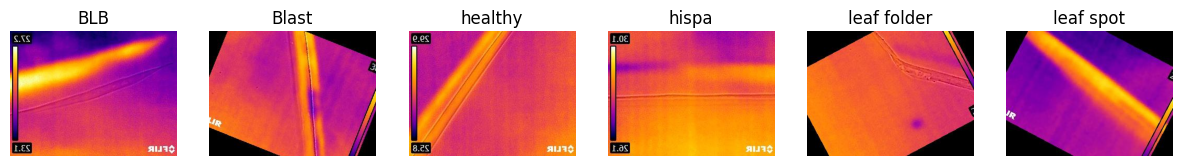

In [19]:
import matplotlib.pyplot as plt
import random

# Function to display one image per class
def display_sample_images(dataset_path):
    fig, axes = plt.subplots(1, len(original_dataset.classes), figsize=(15, 5))
    
    for ax, class_name in zip(axes, original_dataset.classes):
        class_dir = os.path.join(dataset_path, class_name)
        images = os.listdir(class_dir)
        if images:
            img_path = os.path.join(class_dir, random.choice(images))
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(class_name)
            ax.axis("off")

    plt.show()

# Display images
display_sample_images("final_balanced_dataset")


In [83]:
import os
import shutil
import random
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image

# Paths
DATASET_PATH = "thermal images UL"
OUTPUT_PATH = "final_balanced_dataset"
TARGET_IMAGES_PER_CLASS = 2000

# Ensure output directory exists
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Define Transformations
base_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmentation_transforms = [
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
]

# Function to apply transformations and save images
def augment_and_save(image_path, output_folder, count_needed, current_count):
    image = Image.open(image_path).convert("RGB")

    # Stop if target reached
    if current_count >= TARGET_IMAGES_PER_CLASS:
        return current_count

    # Apply augmentations
    for i in range(count_needed):
        if current_count >= TARGET_IMAGES_PER_CLASS:
            break  # Stop if we reached the limit
        
        transform = random.choice(augmentation_transforms)
        augmented_image = transform(image)
        save_path = os.path.join(output_folder, f"aug_{current_count}.jpg")
        augmented_image.save(save_path)
        current_count += 1

    return current_count

# Process each class
classes = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
for cls in classes:
    class_path = os.path.join(DATASET_PATH, cls)
    images = os.listdir(class_path)
    
    # Shuffle images
    random.shuffle(images)
    output_class_path = os.path.join(OUTPUT_PATH, cls)
    os.makedirs(output_class_path, exist_ok=True)

    # Track the number of saved images
    current_count = len(os.listdir(output_class_path))

    # Copy original images first
    for img in images:
        if current_count >= TARGET_IMAGES_PER_CLASS:
            break  # Stop copying if the target is reached

        shutil.copy(os.path.join(class_path, img), os.path.join(output_class_path, img))
        current_count += 1

    # Augment if needed
    if current_count < TARGET_IMAGES_PER_CLASS:
        extra_needed = TARGET_IMAGES_PER_CLASS - current_count
        for img in images:
            if current_count >= TARGET_IMAGES_PER_CLASS:
                break  # Stop augmentation if target reached

            current_count = augment_and_save(os.path.join(class_path, img), output_class_path, extra_needed, current_count)

print(f"✅ Final dataset saved in: {OUTPUT_PATH}, with exactly {TARGET_IMAGES_PER_CLASS} images per class.")


✅ Final dataset saved in: final_balanced_dataset, with exactly 2000 images per class.


In [85]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset, random_split

# Define transformations
base_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define an additional transform for flipping images
flip_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(p=1.0),  # Always flip the image
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load original dataset
original_dataset = ImageFolder(root="final_balanced_dataset", transform=base_transform)

# Load flipped dataset
flipped_dataset = ImageFolder(root="final_balanced_dataset", transform=flip_transform)

# Concatenate datasets to double the size
expanded_dataset = ConcatDataset([original_dataset, flipped_dataset])

# Split into Train, Validation, and Test sets
train_size = int(0.6 * len(expanded_dataset))
val_size = int(0.2 * len(expanded_dataset))
test_size = len(expanded_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(expanded_dataset, [train_size, val_size, test_size])

# Define DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"✅ Dataset Expanded to {len(expanded_dataset)} images!")


✅ Dataset Expanded to 24000 images!


In [87]:
import torch
import torch.nn as nn
import torch.cuda
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pretrained AlexNet model
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[6].in_features  # Get input features of the last FC layer
num_classes = 6  # PlantVillage has 6 classes

# Replace the classifier
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

# Freeze all layers except classifier
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[6].parameters():
    param.requires_grad = True

# Move model to device
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.0001)

# Mixed Precision Training
scaler = torch.cuda.amp.GradScaler()

# DataLoader (AlexNet expects 227x227 images)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Training setup
num_epochs = 10
train_acc_history = []
val_acc_history = []
test_acc_history = []
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    loop = tqdm(train_loader, leave=True, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type="cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=f"{running_loss / len(train_loader):.4f}", acc=f"{100 * correct / total:.2f}%")

    # ✅ Store epoch-wise accuracy
    train_acc_history.append(100 * correct / total)

    # ✅ Validation phase
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    val_acc_history.append(100 * correct_val / total_val)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_history[-1]:.2f}%, Val Acc: {val_acc_history[-1]:.2f}%")


# Save model
torch.save(model.state_dict(), "alexnet_trained.pth")
print("\n🚀 Model saved as alexnet_trained.pth")

Using device: cpu


Epoch 1/10:   0%|                                       | 0/450 [00:00<?, ?it/s]/Users/apple/anaconda3/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 1/10: 100%|████| 450/450 [03:44<00:00,  2.00it/s, acc=91.10%, loss=0.4072]


Epoch 1: Train Acc: 91.10%, Val Acc: 97.27%


Epoch 2/10: 100%|████| 450/450 [03:49<00:00,  1.96it/s, acc=96.81%, loss=0.1518]


Epoch 2: Train Acc: 96.81%, Val Acc: 97.67%


Epoch 3/10: 100%|████| 450/450 [03:35<00:00,  2.09it/s, acc=97.22%, loss=0.1136]


Epoch 3: Train Acc: 97.22%, Val Acc: 97.98%


Epoch 4/10: 100%|████| 450/450 [03:39<00:00,  2.05it/s, acc=97.56%, loss=0.0952]


Epoch 4: Train Acc: 97.56%, Val Acc: 98.06%


Epoch 5/10: 100%|████| 450/450 [03:45<00:00,  2.00it/s, acc=97.81%, loss=0.0824]


Epoch 5: Train Acc: 97.81%, Val Acc: 98.27%


Epoch 6/10: 100%|████| 450/450 [03:57<00:00,  1.90it/s, acc=98.04%, loss=0.0736]


Epoch 6: Train Acc: 98.04%, Val Acc: 98.40%


Epoch 7/10: 100%|████| 450/450 [04:22<00:00,  1.71it/s, acc=98.12%, loss=0.0691]


Epoch 7: Train Acc: 98.12%, Val Acc: 98.40%


Epoch 8/10: 100%|████| 450/450 [03:44<00:00,  2.01it/s, acc=98.20%, loss=0.0634]


Epoch 8: Train Acc: 98.20%, Val Acc: 98.56%


Epoch 9/10: 100%|████| 450/450 [03:53<00:00,  1.93it/s, acc=98.26%, loss=0.0611]


Epoch 9: Train Acc: 98.26%, Val Acc: 98.62%


Epoch 10/10: 100%|███| 450/450 [03:43<00:00,  2.01it/s, acc=98.33%, loss=0.0573]


Epoch 10: Train Acc: 98.33%, Val Acc: 98.71%

🚀 Model saved as alexnet_trained.pth


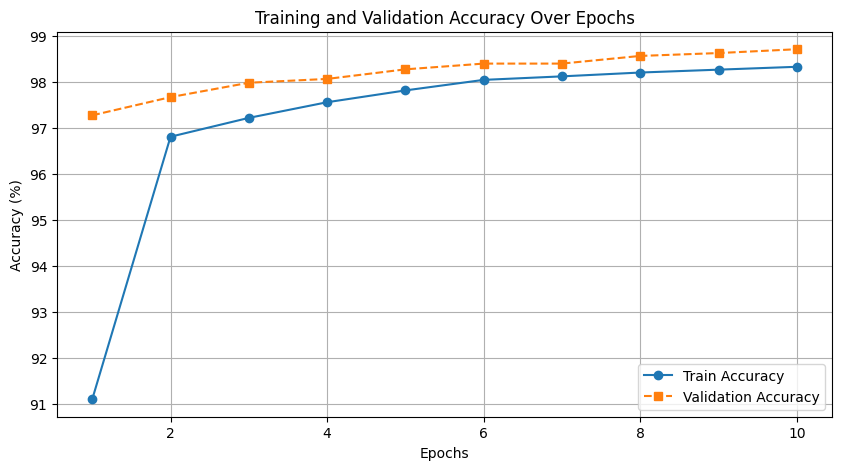

In [89]:
import matplotlib.pyplot as plt

# Ensure accuracy lists have values
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_history, label="Train Accuracy", marker="o", linestyle="-")
plt.plot(epochs, val_acc_history, label="Validation Accuracy", marker="s", linestyle="--")

plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [91]:
import numpy as np
import torch

# Extract class names from the dataset
class_names = original_dataset.classes  # Ensure dataset has class names
num_classes = len(class_names)  # Get the correct number of classes

# Function to calculate per-class accuracy for different datasets
def calculate_per_class_accuracy(model, data_loaders, device, datasets=["Training", "Validation", "Test"]):
    for dataset_type, data_loader in zip(datasets, data_loaders):
        model.eval()
        class_correct = np.zeros(num_classes)  # Match the actual class count
        class_total = np.zeros(num_classes)

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                for i in range(len(labels)):
                    label = labels[i].item()
                    class_correct[label] += (predicted[i] == label).item()
                    class_total[label] += 1

        # Print per-class accuracy
        print(f"\n📊 Final Per-Class {dataset_type} Accuracy:\n")
        for i in range(num_classes):  # Use actual class count
            if class_total[i] > 0:
                accuracy = 100 * class_correct[i] / class_total[i]
                print(f"{class_names[i]}: {dataset_type} = {accuracy:.2f}%")
            else:
                print(f"{class_names[i]}: {dataset_type} = No samples available ❌")

# ---------- Calculate Per-Class Accuracy for Training, Validation, and Test Data ----------
# List of data loaders for training, validation, and test datasets
data_loaders = [train_loader, val_loader, test_loader]

# List of dataset names
datasets = ["Training", "Validation", "Test"]

# Call the function for calculating accuracy
calculate_per_class_accuracy(model, data_loaders, device, datasets=datasets)


📊 Final Per-Class Training Accuracy:

BLB: Training = 98.02%
Blast: Training = 98.68%
healthy: Training = 99.50%
hispa: Training = 98.83%
leaf folder: Training = 99.96%
leaf spot: Training = 98.79%

📊 Final Per-Class Validation Accuracy:

BLB: Validation = 98.33%
Blast: Validation = 97.71%
healthy: Validation = 99.23%
hispa: Validation = 98.74%
leaf folder: Validation = 99.88%
leaf spot: Validation = 98.38%

📊 Final Per-Class Test Accuracy:

BLB: Test = 98.99%
Blast: Test = 97.97%
healthy: Test = 99.14%
hispa: Test = 98.88%
leaf folder: Test = 100.00%
leaf spot: Test = 98.88%


✅ Test Accuracy: 98.98%


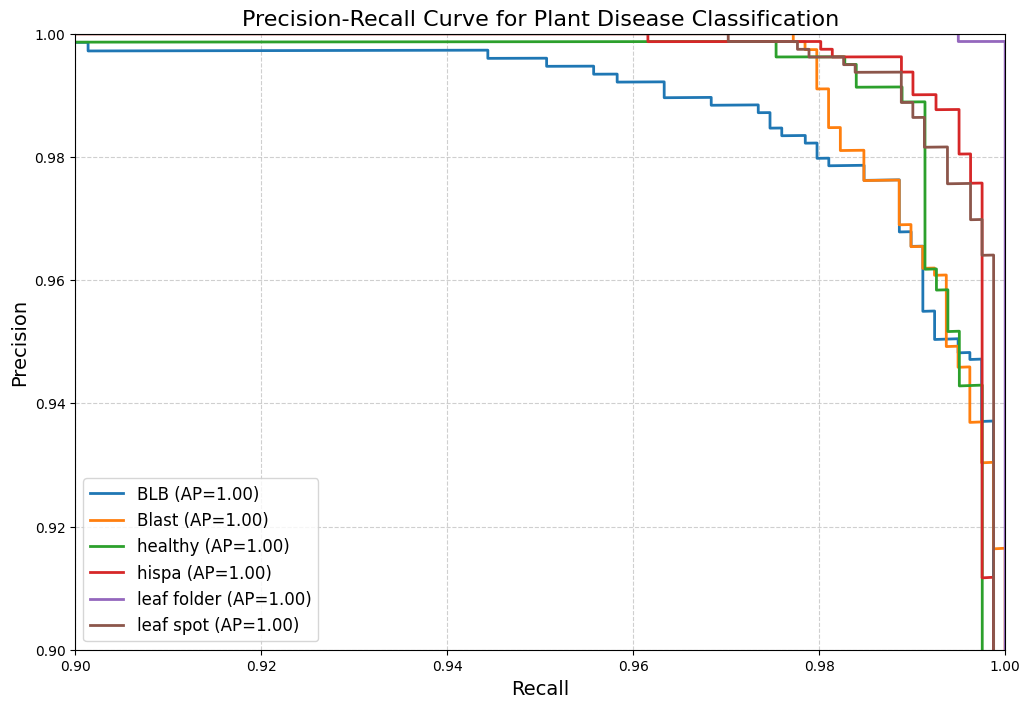

In [97]:
import numpy as np
import torch
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Initialize lists for storing true labels and predicted probabilities
y_true = []
y_scores = []

# Switch to evaluation mode
model.eval()

# Test Accuracy and collect predictions
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"✅ Test Accuracy: {test_acc:.2f}%")

# Collect true labels and predicted probabilities for PR Curve
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

# Convert lists to numpy arrays for PR curve calculation
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Plot Precision-Recall curves for each class
plt.figure(figsize=(12, 8))  # Increased figure size for better visibility
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_true == i, y_scores[:, i])
    avg_precision = average_precision_score(y_true == i, y_scores[:, i])
    
    plt.plot(recall, precision, label=f"{class_names[i]} (AP={avg_precision:.2f})", linewidth=2)

# Enhancing visibility
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision-Recall Curve for Plant Disease Classification", fontsize=16)
plt.xlim([0.9, 1])
plt.ylim([0.9, 1])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12, loc="best")
plt.show()



Enter the folder path containing images:  HomePlants



 Processing images in folder: HomePlants
------------------------------------------------------------
 Early Blight4.jpg ➜ Early Blight (0.96 confidence)


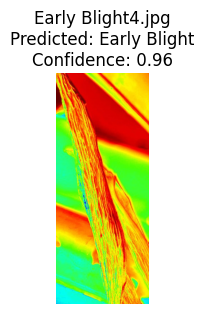

 Early Blight.jpg ➜ Early Blight (0.64 confidence)


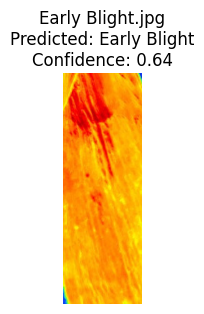

 Late Blight2.jpg ➜ Healthy (0.96 confidence)


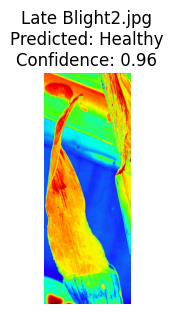

 Late Blight3.jpg ➜ Leaf Mold (0.41 confidence)


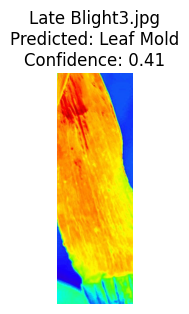

 Healthy.jpg ➜ Healthy (0.95 confidence)


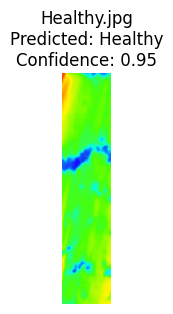

 Late Blight.jpg ➜ Late Blight (0.47 confidence)


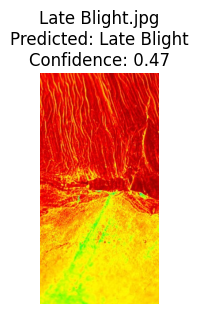

In [57]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔹 Define the model architecture (same as training)
num_classes = 6  # Ensure this matches the training setup

model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

# Load the trained weights
model.load_state_dict(torch.load("alexnet_trained.pth", map_location=device))
model.to(device)
model.eval()  # Set model to evaluation mode

# Define class names (Update this with your actual class labels)
class_names = ["Healthy", "Bacterial Spot", "Early Blight", "Late Blight", "Leaf Mold", "Mosaic Virus"]  

# Define image transformations (same as training)
image_transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Resize to match AlexNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_image(image_path, model, class_names):
    """Loads an image, applies transformations, and predicts the class using AlexNet."""
    
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = image_transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.nn.functional.softmax(output, dim=1)  # Convert to probabilities
        predicted_class_idx = torch.argmax(probs, dim=1).item()
        predicted_class_name = class_names[predicted_class_idx]
        confidence = probs[0, predicted_class_idx].item()

    return predicted_class_name, confidence, image

def predict_folder(folder_path, model, class_names):
    """Processes all images in a given folder, prints predictions, and displays images."""
    
    if not os.path.exists(folder_path):
        print(f"❌ Error: Folder '{folder_path}' not found.")
        return

    # Get all image files from the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(" No image files found in the folder.")
        return

    print("\n Processing images in folder:", folder_path)
    print("-" * 60)

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        predicted_class, confidence, image = predict_image(img_path, model, class_names)

        # Print prediction
        print(f" {img_file} ➜ {predicted_class} ({confidence:.2f} confidence)")

        # Display image with prediction
        plt.figure(figsize=(3, 3))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"{img_file}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}", fontsize=12)
        plt.show()

# 🔹 Example usage: Take folder input from user
folder_path = input("Enter the folder path containing images: ")
predict_folder(folder_path, model, class_names)


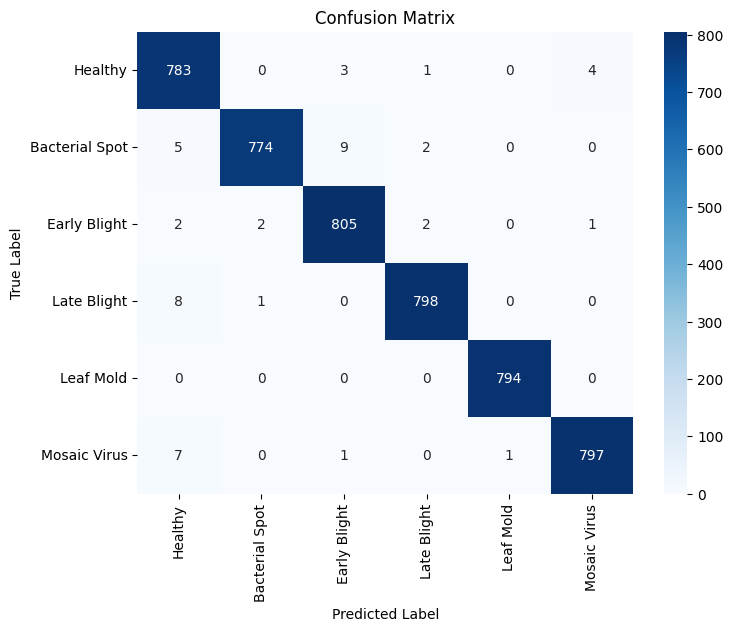

Classification Report:
                 precision    recall  f1-score   support

       Healthy       0.97      0.99      0.98       791
Bacterial Spot       1.00      0.98      0.99       790
  Early Blight       0.98      0.99      0.99       812
   Late Blight       0.99      0.99      0.99       807
     Leaf Mold       1.00      1.00      1.00       794
  Mosaic Virus       0.99      0.99      0.99       806

      accuracy                           0.99      4800
     macro avg       0.99      0.99      0.99      4800
  weighted avg       0.99      0.99      0.99      4800



In [101]:
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Initialize lists for true labels and predictions
y_true = []
y_pred = []

# Set model to evaluation mode
model.eval()

# Collect predictions
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=class_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print precision, recall, and F1-score
print("Classification Report:\n", class_report)


Enter the folder path containing images:  HomePlants



 Processing images in folder: HomePlants
------------------------------------------------------------
 Early Blight4.jpg ➜ Early Blight (0.96 confidence)


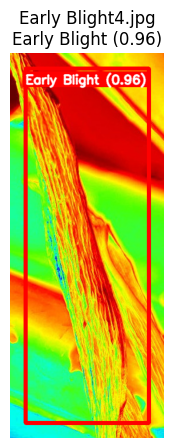

 Early Blight.jpg ➜ Early Blight (0.64 confidence)


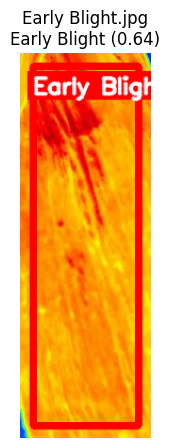

 Late Blight2.jpg ➜ Healthy (0.96 confidence)


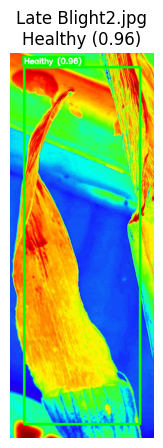

 Late Blight3.jpg ➜ Leaf Mold (0.41 confidence)


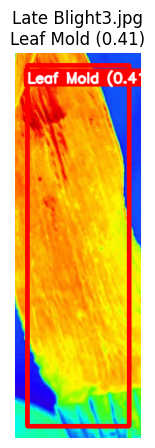

 Healthy.jpg ➜ Healthy (0.95 confidence)


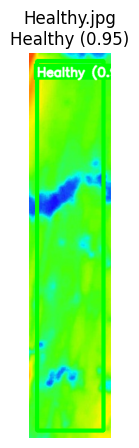

 Late Blight.jpg ➜ Late Blight (0.47 confidence)


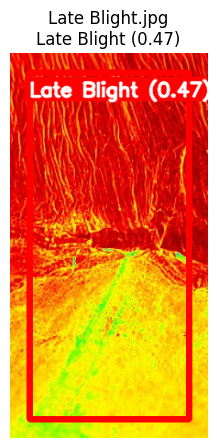


 Combined image saved as 'combined_result.png'


In [61]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load AlexNet model and modify for classification
num_classes = 6  # Adjust according to your dataset
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

# Load trained weights
model.load_state_dict(torch.load("alexnet_trained.pth", map_location=device))
model.to(device)
model.eval()

# Define class names
class_names = ["Healthy", "Bacterial Spot", "Early Blight", "Late Blight", "Leaf Mold", "Mosaic Virus"]

# Define image transformations
image_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def draw_bounding_box(image, predicted_class, confidence):
    """Draws a bounding box inside the image with label and confidence score."""
    image_cv = np.array(image)
    image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)

    color = (0, 255, 0) if predicted_class == "Healthy" else (0, 0, 255)  # Green for Healthy, Red for Diseased
    
    h, w, _ = image_cv.shape
    margin = int(min(h, w) * 0.1)  # 10% margin
    x1, y1 = margin, margin
    x2, y2 = w - margin, h - margin

    cv2.rectangle(image_cv, (x1, y1), (x2, y2), color, thickness=5)

    label = f"{predicted_class} ({confidence:.2f})"
    font_scale, font_thickness = 0.7, 2
    text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)[0]
    text_x, text_y = x1, y1 - 10

    if text_y < 20:
        text_y = y1 + text_size[1] + 10

    cv2.rectangle(image_cv, (text_x - 5, text_y - text_size[1] - 5), 
                  (text_x + text_size[0] + 5, text_y + 5), color, -1)
    
    cv2.putText(image_cv, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 
                font_scale, (255, 255, 255), font_thickness, lineType=cv2.LINE_AA)

    return image_cv

def predict_image(image_path, model, class_names):
    """Loads an image, applies transformations, and predicts the class using AlexNet."""
    image = Image.open(image_path).convert("RGB")
    input_tensor = image_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.nn.functional.softmax(output, dim=1)
        predicted_class_idx = torch.argmax(probs, dim=1).item()
        predicted_class_name = class_names[predicted_class_idx]
        confidence = probs[0, predicted_class_idx].item()

    return predicted_class_name, confidence, image

def predict_folder(folder_path, model, class_names, save_path="combined_result.png"):
    """Processes all images, draws bounding boxes, displays them, and saves as a combined image."""
    if not os.path.exists(folder_path):
        print(f" Error: Folder '{folder_path}' not found.")
        return

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        print(" No image files found in the folder.")
        return

    print("\n Processing images in folder:", folder_path)
    print("-" * 60)

    processed_images = []

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        predicted_class, confidence, image = predict_image(img_path, model, class_names)

        print(f" {img_file} ➜ {predicted_class} ({confidence:.2f} confidence)")

        image_with_box = draw_bounding_box(image, predicted_class, confidence)
        image_pil = Image.fromarray(cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB))
        processed_images.append(image_pil)

        # Display image
        plt.figure(figsize=(5, 5))
        plt.imshow(image_pil)
        plt.axis("off")
        plt.title(f"{img_file}\n{predicted_class} ({confidence:.2f})")
        plt.show()

    if processed_images:
        combined_image = combine_images(processed_images)
        combined_image.save(save_path)
        print(f"\n Combined image saved as '{save_path}'")
        combined_image.show()

def combine_images(images, spacing=10, max_width=1500):
    """Combines multiple images into a single image, arranging them into rows if needed."""
    target_height = max(img.height for img in images)
    resized_images = [img.resize((int(img.width * (target_height / img.height)), target_height)) for img in images]

    total_width = sum(img.width for img in resized_images) + (spacing * (len(images) - 1))
    
    if total_width > max_width:
        cols = max_width // resized_images[0].width
        rows = (len(images) + cols - 1) // cols

        combined_img = Image.new("RGB", (max_width, target_height * rows + (spacing * (rows - 1))), (255, 255, 255))
        x_offset, y_offset = 0, 0
        for idx, img in enumerate(resized_images):
            combined_img.paste(img, (x_offset, y_offset))
            x_offset += img.width + spacing
            if (idx + 1) % cols == 0:
                x_offset = 0
                y_offset += target_height + spacing
    else:
        combined_img = Image.new("RGB", (total_width, target_height), (255, 255, 255))
        x_offset = 0
        for img in resized_images:
            combined_img.paste(img, (x_offset, 0))
            x_offset += img.width + spacing

    return combined_img

# Example usage: Take folder input from user
folder_path = input("Enter the folder path containing images: ")
predict_folder(folder_path, model, class_names)
